In [1]:
library(tidyverse)
library(directlabels)
library(readxl)
library(gghighlight)

#Brazil cases
corona_brazil_original <- read_csv("https://brasil.io/dataset/covid19/caso/?format=csv",
                                   col_types = cols(date = col_date(format = "%Y-%m-%d"),
                                                    state = col_character(),
                                                    city = col_character(),
                                                    place_type = col_character(),
                                                    confirmed = col_double(),
                                                    deaths = col_double(),
                                                    is_last = col_logical(),
                                                    estimated_population_2019 = col_double(),
                                                    city_ibge_code = col_character(),
                                                    confirmed_per_100k_inhabitants = col_double(),
                                                    death_rate = col_double())
)

regioes_geograficas <- read_csv("C:/Users/caioe/Downloads/regioes_geograficas.csv",
                                col_types = (
                                  cols(
                                    nome_mun = col_character(),
                                    CD_GEOCODI = col_character(),
                                    cod_rgi = col_character(),
                                    nome_rgi = col_character(),
                                    cod_rgint = col_character(),
                                    nome_rgint = col_character(),
                                    State = col_character(),
                                    State2 = col_character(),
                                    Divisao = col_character())
                                ))

regioes_geograficas_divisao <- regioes_geograficas %>% 
  select(State2,Divisao) %>% 
  group_by(State2,Divisao) %>% 
  distinct(State2,Divisao)

municipios <- read_excel("C:/Users/caioe/Desktop/r4ds/DTB_2018/RELATORIO_DTB_BRASIL_MUNICIPIO.xls")
municipios <- municipios %>%
    select()

corona_brazil <- corona_brazil_original %>%
  left_join(regioes_geograficas_divisao, by = c("state" = "State2")) %>% 
  replace_na(list(confirmed = 0,
                  deaths = 0)) %>% 
  group_by(city_ibge_code) %>% 
  arrange(date,city_ibge_code) %>% 
  mutate(new_confirmed = confirmed - lag(confirmed),
         new_deaths = deaths - lag(deaths))

options(warn=-1)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.2"Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'readr' was built under R version 3.6.2"Warning message:
"package 'purrr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'directlabels' was built under R version 3.6.3"Warning

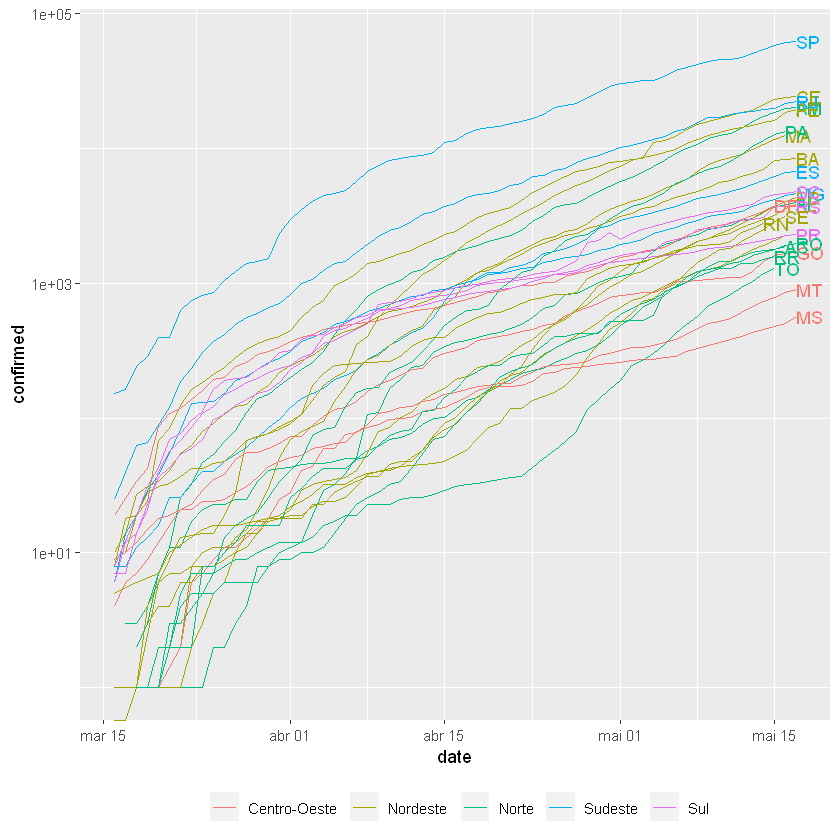

In [2]:
#coincident
brazil_cases_coincident <- corona_brazil %>% 
  filter(is.na(city) , date >= "2020-03-16") %>% 
  ggplot(mapping = aes(x = date, y = confirmed, group = state, colour = Divisao)) +
  geom_line() + scale_y_log10() +
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9)) + 
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank()) 
brazil_cases_coincident

options(repr.plot.width=7, repr.plot.height=5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


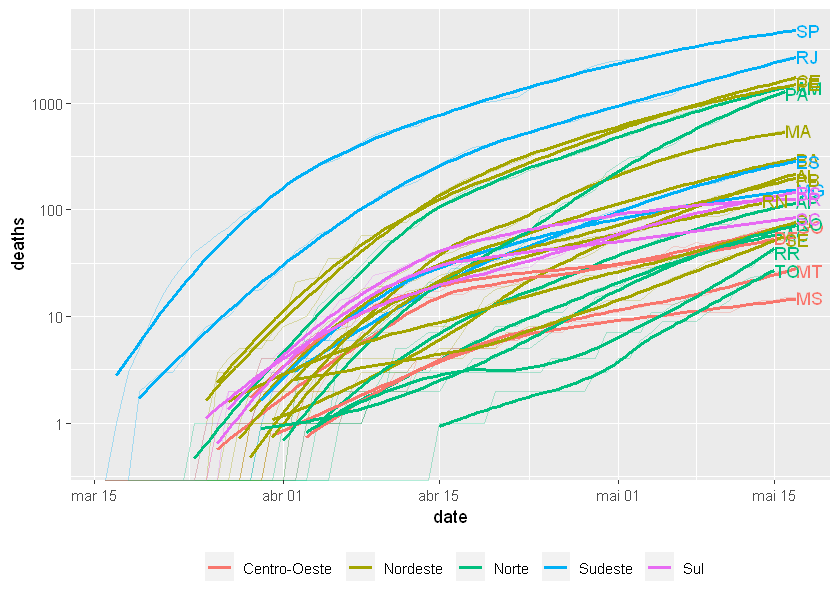

In [3]:
brazil_deaths_coincident <- corona_brazil %>% 
  filter(is.na(city) , date >= "2020-03-16") %>% 
  ggplot(mapping = aes(x = date, y = deaths, group = state, colour = Divisao)) +
  geom_line(alpha = 0.3) + 
  geom_smooth(se = FALSE) +
  scale_y_log10() +
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9)) + 
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank()) 
brazil_deaths_coincident

options(repr.plot.width=7, repr.plot.height=5)

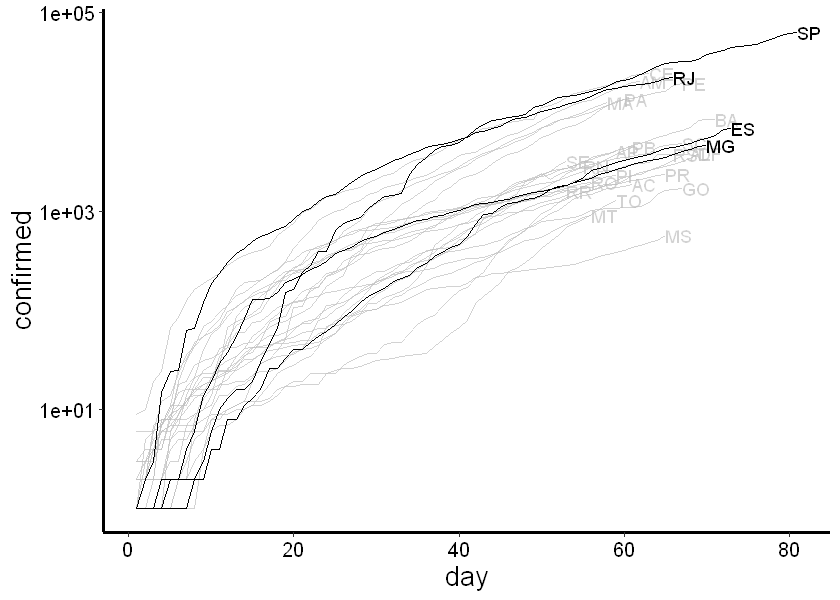

In [4]:
#cohort
brazil_cases_cohort <- corona_brazil %>% 
  filter(is.na(city), confirmed > 0) %>%
  group_by(state) %>% 
  arrange(date, state) %>% 
  mutate(day = row_number()) %>% 
  ggplot(mapping = aes(x = day, y = confirmed, group = state)) +
  stat_smooth(method = 'nls', 
              formula = y ~ a*2^(day/7), 
              aes(colour = 'Exponential'),
              se = TRUE, 
              start = list(a = 1)) +
  geom_line()+
  scale_y_log10() +
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9)) + 
  theme(legend.position = "bottom", legend.box = "horizontal", 
        legend.title = element_blank(),
        axis.line = element_line(size=1, colour = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        plot.title=element_text(size = 20, family="xkcd-Regular"),
        text=element_text(size = 16, family="xkcd-Regular"),
        axis.text.x=element_text(colour="black", size = 12),
        axis.text.y=element_text(colour="black", size = 12)) +
  gghighlight(aes(color = state), Divisao == "Sudeste", use_direct_label = FALSE)
brazil_cases_cohort

options(repr.plot.width=7, repr.plot.height=5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


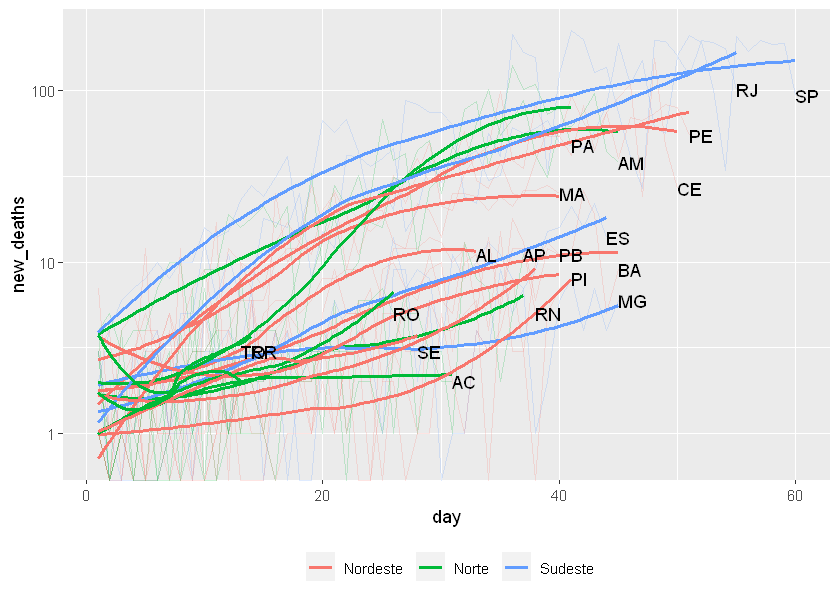

In [5]:
corona_brazil %>% 
  filter(is.na(city), 
         deaths >= 5,
         Divisao %in% c('Sudeste','Nordeste','Norte')) %>%
  group_by(state) %>% 
  arrange(date, state) %>% 
  mutate(day = row_number()) %>% 
  ggplot(mapping = aes(x = day, y = new_deaths, group = state, colour = Divisao)) +
  geom_line(alpha = 0.2) + 
  scale_y_log10() +
  geom_smooth(se = FALSE, span = 0.9) +
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9),color = "Black") + 
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank())

options(repr.plot.width=7, repr.plot.height=5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


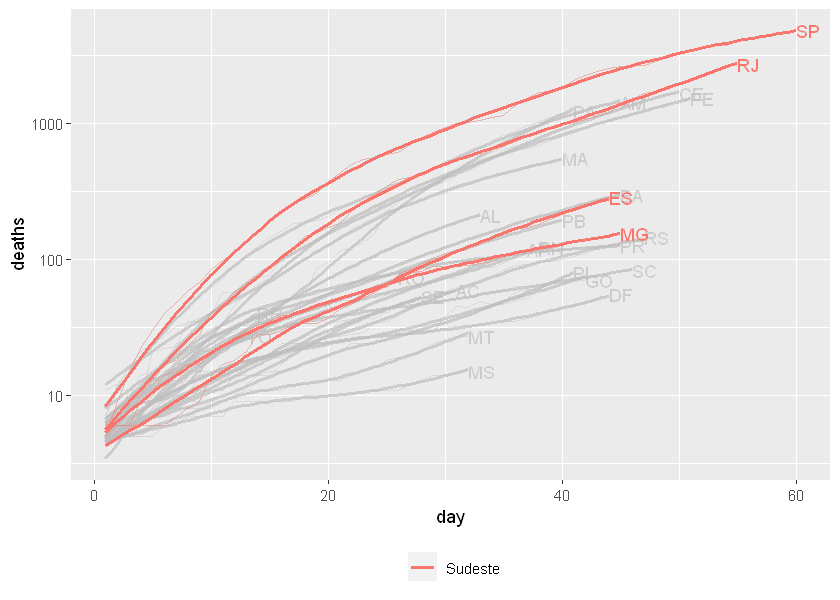

In [6]:
brazil_deaths_cohort <- corona_brazil %>% 
  filter(is.na(city), deaths >= 5) %>%
  group_by(state) %>% 
  arrange(date, state) %>% 
  mutate(day = row_number()) %>% 
  ggplot(mapping = aes(x = day, y = deaths, group = state, colour = Divisao)) +
  geom_line(alpha = 0.4) + scale_y_log10() +
  geom_smooth(se = FALSE, span = 0.7) +
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9)) + 
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank()) +
  gghighlight(aes(color = state), Divisao == "Sudeste", use_direct_label = FALSE)
brazil_deaths_cohort

options(repr.plot.width=7, repr.plot.height=5)

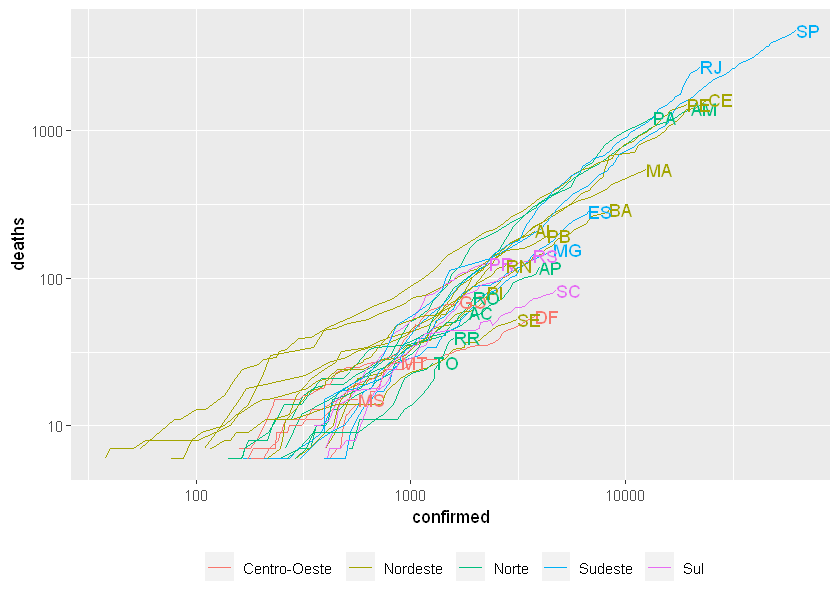

In [7]:
brazil_rate_cohort <- corona_brazil %>% 
  filter(is.na(city), deaths > 5) %>%
  group_by(state) %>% 
  arrange(date, state) %>% 
  mutate(day = row_number()) %>% 
  ggplot(mapping = aes(x = confirmed, y = deaths, group = state, colour = Divisao)) +
  geom_line() + scale_y_log10() + scale_x_log10()+
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9)) + 
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank()) 
brazil_rate_cohort

options(repr.plot.width=7, repr.plot.height=5)

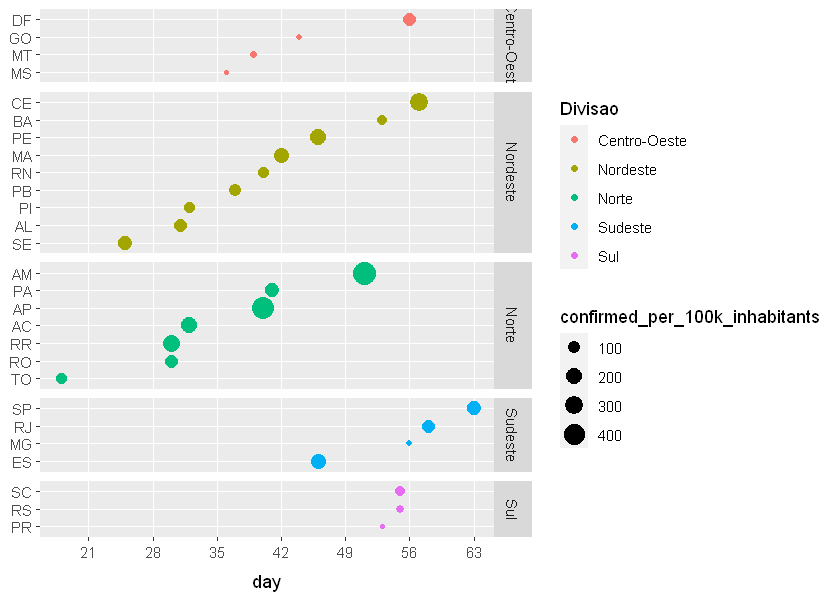

In [8]:
brazil_days_diff <- corona_brazil %>% 
  filter(is.na(city), confirmed > 100) %>%
  group_by(state) %>% 
  arrange(date, state) %>% 
  mutate(day = row_number()) %>%
  filter(day == max(day)) %>% 
  ggplot(mapping = aes(x = day, fct_reorder(state,day),colour = Divisao, size = confirmed_per_100k_inhabitants)) +
  geom_point() +
  theme(axis.title.y = element_blank(),
        panel.grid.minor = element_blank()) +
  scale_x_continuous(breaks = seq(0, 100, by = 7)) +
  facet_grid(rows = vars(Divisao),
               scales = "free",
               space = "free")
brazil_days_diff

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


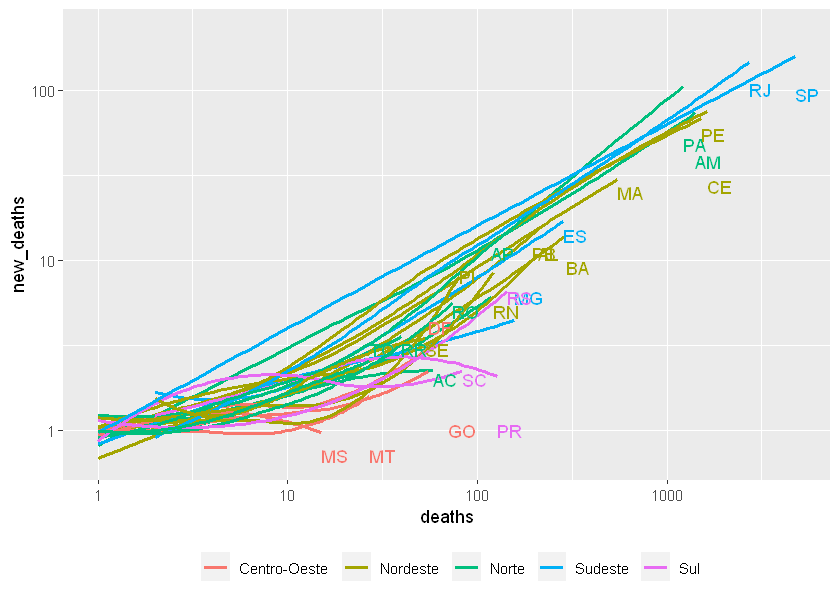

In [9]:
brazil_tendency <- corona_brazil %>% 
  filter(is.na(city), confirmed > 0) %>%
  group_by(state) %>% 
  arrange(date, state) %>% 
  mutate(day = row_number()) %>% 
  ggplot(mapping = aes(x = deaths, y = new_deaths, group = state, colour = Divisao)) +
  geom_smooth(se = FALSE, span = 1) + scale_y_log10() + scale_x_log10()+
  geom_dl(aes(label = state), method = list(dl.combine("last.points"), cex = 0.9)) + 
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank()) 
brazil_tendency

options(repr.plot.width=7, repr.plot.height=5)

# São Paulo

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


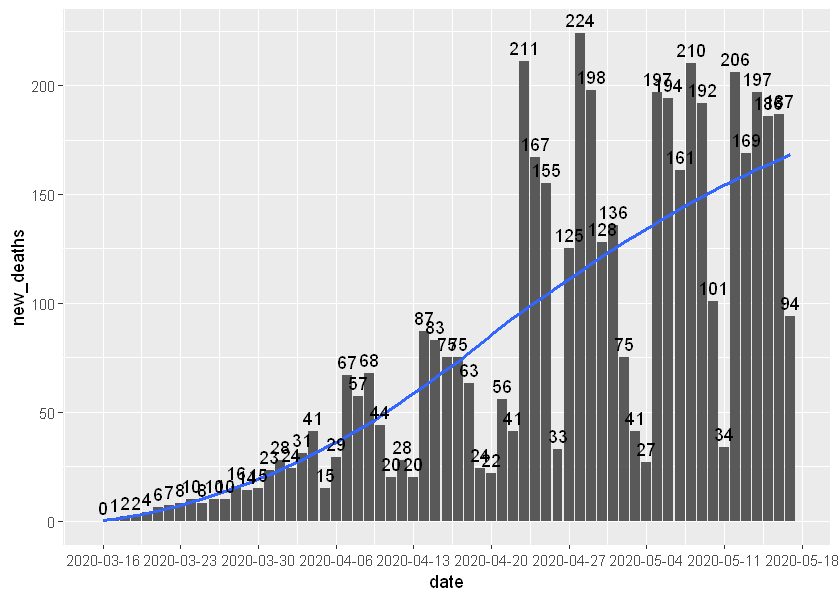

In [10]:
sp_new_deaths <- corona_brazil %>% 
  filter(is.na(city) , date >= "2020-03-16", state == 'SP') %>% 
  ggplot(mapping = aes(x = date, y = new_deaths)) +
  geom_col() +
  geom_smooth(se = FALSE, span = 1) +
  geom_text(aes(label = new_deaths, vjust = -0.5)) +
  scale_x_date(breaks = "1 week")
sp_new_deaths

options(repr.plot.width=7, repr.plot.height=5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


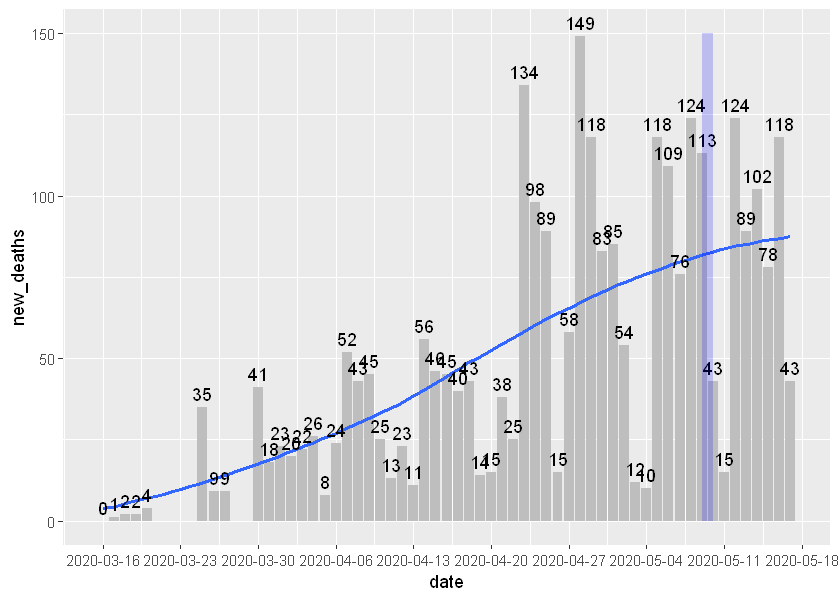

In [11]:
corona_brazil %>% 
  filter(city == "São Paulo" , date >= "2020-03-16") %>% 
  ggplot(mapping = aes(x = date, y = new_deaths)) +
  geom_col(fill = "gray", alpha = 1) +
  geom_smooth(se = FALSE, span = 1) +
  geom_text(aes(label = new_deaths, vjust = -0.5)) +
  scale_x_date(breaks = "1 week") +
  annotate("rect", 
           xmin = as.Date('2020-05-09', "%Y-%m-%d"),
           xmax = as.Date('2020-05-10', "%Y-%m-%d"),
           ymin = 0,
           ymax = 150,
           alpha = 0.2,
           fill = "blue")

options(repr.plot.width=7, repr.plot.height=5)

In [12]:
corona_brazil %>% 
  filter(!is.na(city), 
         is_last == TRUE, 
         state == 'SP') %>%
  arrange(-confirmed) %>%
  select(city,
        confirmed,
        deaths,
        death_rate,
        confirmed_per_100k_inhabitants,
        estimated_population_2019) %>%
  head(30)

Adding missing grouping variables: `city_ibge_code`


city_ibge_code,city,confirmed,deaths,death_rate,confirmed_per_100k_inhabitants,estimated_population_2019
3550308,São Paulo,35931,2835,0.0789,293.26585,12252023
3534401,Osasco,1731,203,0.1173,247.84585,698418
3518800,Guarulhos,1528,165,0.1080,110.79031,1379182
3548708,São Bernardo do Campo,1446,120,0.0830,172.36118,838936
3548500,Santos,1397,86,0.0616,322.40123,433311
3547809,Santo André,1296,68,0.0525,180.30727,718773
3509502,Campinas,987,37,0.0375,81.97177,1204073
3505708,Barueri,728,82,0.1126,265.51707,274182
3513801,Diadema,637,51,0.0801,150.27696,423884
3530607,Mogi das Cruzes,613,43,0.0701,137.49265,445842


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


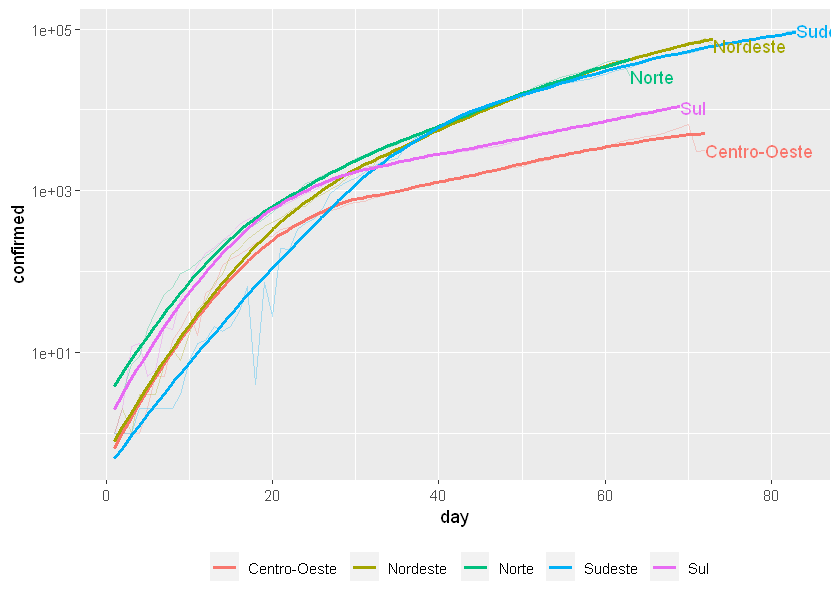

In [13]:
corona_brazil %>% 
  filter(is.na(city), confirmed > 0) %>%
  group_by(date, Divisao) %>% 
  arrange(date, Divisao) %>%
  summarise(confirmed = sum(confirmed)) %>%
  ungroup() %>%
  group_by(Divisao) %>%
  mutate(day = row_number()) %>%
  ggplot(mapping = aes(x = day, y = confirmed, colour = Divisao)) +
  geom_line(alpha = 0.3) +
  geom_smooth(se = FALSE) +
  scale_y_log10() +
  geom_dl(aes(label = Divisao), method = list(dl.combine("last.points"), cex = 0.9)) +
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank())

options(repr.plot.width=7, repr.plot.height=5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


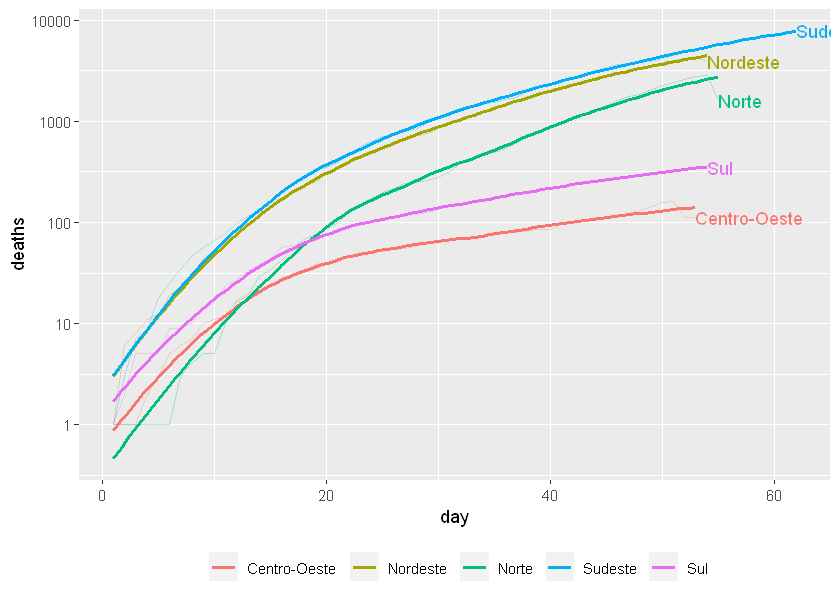

In [14]:
corona_brazil %>% 
  filter(is.na(city), deaths > 0) %>%
  group_by(date, Divisao) %>% 
  arrange(date, Divisao) %>%
  summarise(deaths = sum(deaths)) %>%
  ungroup() %>%
  group_by(Divisao) %>%
  mutate(day = row_number()) %>%
  ggplot(mapping = aes(x = day, y = deaths, colour = Divisao)) +
  geom_line(alpha = 0.3) +
  geom_smooth(se = FALSE) +
  scale_y_log10() +
  geom_dl(aes(label = Divisao), method = list(dl.combine("last.points"), cex = 0.9)) +
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank())

options(repr.plot.width=7, repr.plot.height=5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


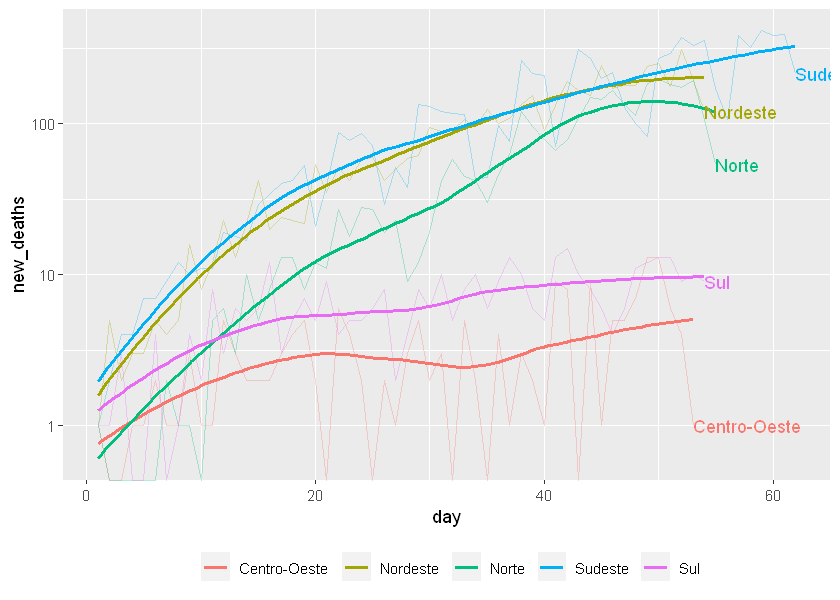

In [15]:
corona_brazil %>% 
  filter(is.na(city), deaths > 0) %>%
  group_by(date, Divisao) %>% 
  arrange(date, Divisao) %>%
  summarise(new_deaths = sum(new_deaths)) %>%
  ungroup() %>%
  group_by(Divisao) %>%
  mutate(day = row_number()) %>%
  ggplot(mapping = aes(x = day, y = new_deaths, colour = Divisao)) +
  geom_line(alpha = 0.3) +
  geom_smooth(se = FALSE) +
  scale_y_log10() +
  geom_dl(aes(label = Divisao), method = list(dl.combine("last.points"), cex = 0.9)) +
  theme(legend.position = "bottom", legend.box = "horizontal") + 
  theme(legend.title = element_blank())

options(repr.plot.width=7, repr.plot.height=5)

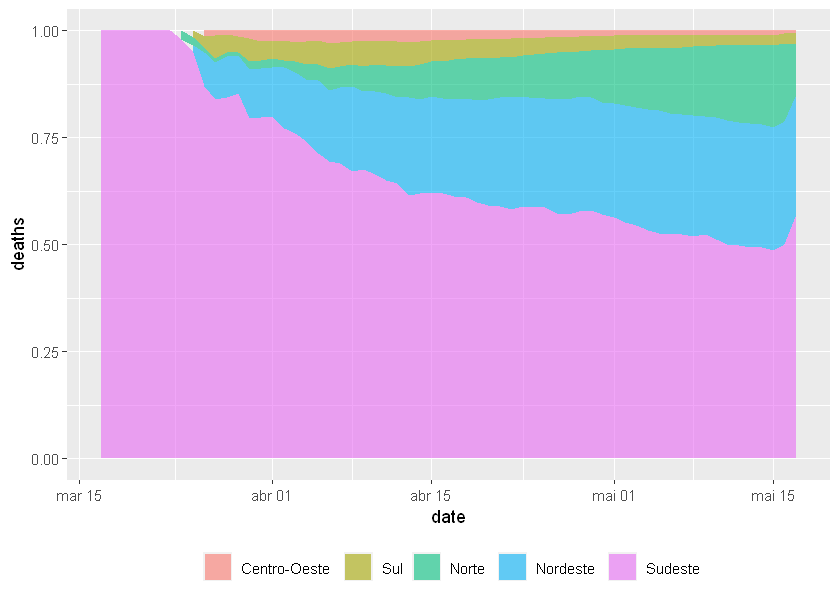

In [16]:
corona_brazil %>% 
  filter(is.na(city), deaths > 0) %>%
  group_by(date, Divisao) %>% 
  arrange(date, Divisao) %>%
  summarise(deaths = sum(deaths)) %>%
  ggplot(mapping = aes(x = date, y = deaths, fill = factor(Divisao, levels = c("Centro-Oeste",
                                                                              "Sul",
                                                                              "Norte",
                                                                              "Nordeste",
                                                                              "Sudeste")))) +
  geom_area(position = "fill",
           alpha = 0.6) +
  labs(fill = "") +
  theme(legend.position = "bottom", legend.box = "horizontal")

options(repr.plot.width=7, repr.plot.height=5)